In [1]:
from datetime import datetime
from functools import reduce
import math as mt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
l=5

In [3]:
df = pd.read_csv('time_series_covid19_confirmed_US.csv')
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/11/2021,2/12/2021,2/13/2021,2/14/2021,2/15/2021,2/16/2021,2/17/2021,2/18/2021,2/19/2021,2/20/2021
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5970,5984,6002,6023,6024,6038,6050,6071,6079,6092
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,18960,18994,19051,19105,19136,19176,19267,19324,19361,19392
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2030,2036,2040,2042,2044,2055,2053,2057,2061,2067
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2377,2385,2393,2395,2397,2400,2399,2405,2411,2414
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5955,5953,5957,5961,5973,5987,5997,6008,6021,6040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,3256,3267,3267,3278,3278,3297,3298,3307,3318,3318
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,1992,1994,1994,1994,1994,2007,2016,2021,2024,2024
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,872,873,873,873,873,874,874,875,877,877


In [4]:
df.shape

(3340, 407)

In [5]:
mt.floor((df.shape[1] -11)*0.8)

316

In [6]:
df.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '2/11/2021', '2/12/2021', '2/13/2021', '2/14/2021', '2/15/2021',
       '2/16/2021', '2/17/2021', '2/18/2021', '2/19/2021', '2/20/2021'],
      dtype='object', length=407)

In [7]:
df.Province_State.unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [8]:
df.iloc[:, 11:380]

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,1/15/2021,1/16/2021,1/17/2021,1/18/2021,1/19/2021,1/20/2021,1/21/2021,1/22/2021,1/23/2021,1/24/2021
0,0,0,0,0,0,0,0,0,0,0,...,5103,5154,5184,5198,5227,5257,5270,5327,5358,5376
1,0,0,0,0,0,0,0,0,0,0,...,16002,16176,16251,16346,16513,16653,16798,16981,17128,17256
2,0,0,0,0,0,0,0,0,0,0,...,1712,1723,1729,1730,1738,1760,1778,1793,1805,1827
3,0,0,0,0,0,0,0,0,0,0,...,2130,2144,2151,2162,2170,2188,2198,2212,2223,2223
4,0,0,0,0,0,0,0,0,0,0,...,5264,5292,5304,5308,5320,5376,5411,5439,5462,5473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,0,0,0,0,0,0,0,0,0,0,...,2605,2614,2685,2753,2769,2788,2847,2870,2870,2931
3336,0,0,0,0,0,0,0,0,0,0,...,1806,1813,1817,1833,1843,1852,1874,1887,1887,1900
3337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3338,0,0,0,0,0,0,0,0,0,0,...,840,842,843,844,846,846,848,853,853,858


In [9]:
def get_list(x, m):
    return list(zip(*(x[i:] for i in range(m))))

In [10]:
def get_data(input_df,lag):
    dft = input_df.transpose().rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
    dft = dft.iloc[1:]
    print(dft.shape)
    w = lag
    x = []
    print(dft.shape[1])
    for i in range(dft.shape[1]):
        x.extend(get_list(dft[i], w+1))

    x = np.array(x)

    y = torch.tensor(x[:, -1])
    x = torch.tensor(x[:, :-1])
    return x, y

In [11]:
x_train = torch.empty(mt.floor((df.shape[1] -11)*0.8), l)
y_train = torch.empty(mt.floor((df.shape[1] -11)*0.8))

In [12]:
print(y_train.shape)

torch.Size([316])


In [13]:
print(x_train.shape)

torch.Size([316, 5])


In [14]:
x_test = torch.empty((df.shape[1]-11)- mt.floor((df.shape[1] -11)*0.8) , l)
y_test = torch.empty((df.shape[1]-11)- mt.floor((df.shape[1] -11)*0.8))

In [15]:
print(x_test.shape)

torch.Size([80, 5])


In [16]:
print(y_test.shape)

torch.Size([80])


In [17]:
mt.floor((df.shape[1] -11)*0.8)

316

In [18]:
x_train, y_train = get_data(df.iloc[:, 11:mt.floor((df.shape[1])*0.8)]+11,l)

(313, 3340)
3340


In [108]:
print(x_train.shape)

torch.Size([1028720, 5])


In [103]:
dft = (df.iloc[:, 11:mt.floor((df.shape[1])*0.8)]+11).transpose().rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

In [106]:
dft[0]

1/22/2020      NaN
1/23/2020      0.0
1/24/2020      0.0
1/25/2020      0.0
1/26/2020      0.0
              ... 
11/26/2020    18.0
11/27/2020    12.0
11/28/2020    19.0
11/29/2020    16.0
11/30/2020    29.0
Name: 0, Length: 314, dtype: float64

In [104]:
dft

,0,1,2,3,4,5,6,7,8,9,...,3330,3331,3332,3333,3334,3335,3336,3337,3338,3339
1/22/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/26/2020,18.0,103.0,0.0,8.0,24.0,3.0,9.0,103.0,27.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11/27/2020,12.0,27.0,1.0,3.0,9.0,0.0,0.0,25.0,1.0,5.0,...,29.0,13.0,60.0,14.0,176.0,71.0,21.0,0.0,20.0,10.0
11/28/2020,19.0,130.0,2.0,6.0,34.0,2.0,12.0,61.0,3.0,7.0,...,5.0,3.0,15.0,3.0,6.0,23.0,0.0,0.0,2.0,0.0
11/29/2020,16.0,87.0,2.0,9.0,24.0,4.0,8.0,65.0,4.0,7.0,...,14.0,7.0,37.0,9.0,32.0,36.0,9.0,0.0,11.0,0.0


In [19]:
print(x_train.shape)

torch.Size([1028720, 5])


In [20]:
x_test, y_test = get_data(df.iloc[:, mt.floor((df.shape[1])*0.8)+1:],l)

(80, 3340)
3340


In [21]:
print(x_test.shape)

torch.Size([250500, 5])


In [22]:
class AutoRegressive(nn.Module):
    def __init__(self, p):
        # Input the AR parameters
        # Building only for linear data for now
        super(AutoRegressive, self).__init__()
        assert type(p) == int
        assert p >= 0
        
        # Initialize Auto Regressive parameter
        self.p = p
        
        # Linear auto-regressive parameters.
#         self.param_list = nn.ModuleList([nn.Linear(1, 1, bias=False) for i in range(p-1)])
        
        self.linear = nn.Linear(self.p, 1, bias=True).double()
         
        # ETA e(t) for noise , which is last layer dependent
#         self.param_list.append(nn.Linear(1, 1, bias=True))
        
        # One Learnable parameter for constant c
#         self.c = nn.Parameter(torch.tensor(np.random.randn(), requires_grad=True))
        
    def forward(self, x):
        # Input data example
        # Verify shape of tensor to have length (1,p) or something.
        assert x.shape[1] == self.p
        
#         y = self.linear(x)
        
#         for i in range(self.p):
#             print(self.param_list[i].features)
#             y += x[:, i] * self.param_list[i]
        
#         simple_sum = reduce(lambda x,y: x + y, [self.param_list[i](x[i]) for i in range(self.p)])
        
        return self.linear(x).flatten() #+ self.c

In [24]:
net2 = AutoRegressive(l)

In [25]:
optimizer = torch.optim.RMSprop(net2.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')

In [27]:
train_loader = DataLoader(
    TensorDataset(x_train, y_train), batch_size=3000, shuffle=True
)

In [30]:
for e in range(10):
    loss_total = 0
    for xi, yi in tqdm(train_loader):
        xi, yi = xi.to('cpu'), yi.to('cpu')
        optimizer.zero_grad()
        prediction = net2(xi)
        loss = criterion(yi, prediction)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_total += loss
        
    print(e, loss_total / len(y_train))

  0%|          | 1/343 [00:00<00:50,  6.74it/s]

0 tensor(0.6538, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 1/343 [00:00<00:58,  5.83it/s]

1 tensor(0.6482, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 1/343 [00:00<00:58,  5.81it/s]

2 tensor(0.6453, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 1/343 [00:00<01:01,  5.55it/s]

3 tensor(0.6447, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 0/343 [00:00<?, ?it/s]

4 tensor(0.6444, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 1/343 [00:00<01:02,  5.48it/s]

5 tensor(0.6443, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 0/343 [00:00<?, ?it/s]

6 tensor(0.6442, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 1/343 [00:00<00:55,  6.18it/s]

7 tensor(0.6440, dtype=torch.float64, grad_fn=<DivBackward0>)


  0%|          | 1/343 [00:00<00:59,  5.79it/s]

8 tensor(0.6439, dtype=torch.float64, grad_fn=<DivBackward0>)


100%|██████████| 343/343 [00:17<00:00, 19.55it/s]

9 tensor(0.6442, dtype=torch.float64, grad_fn=<DivBackward0>)


In [32]:
test_loader = DataLoader(
    TensorDataset(x_test, y_test), batch_size=3000, shuffle=True
)

In [42]:
for e in range(10):
    loss_total = 0
    for xi, yi in tqdm(test_loader):
        xi, yi = xi.to('cpu'), yi.to('cpu')
        optimizer.zero_grad()
        prediction[yi] = net2(xi)
        loss = criterion(yi, prediction)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_total += loss
        
    print(e, loss_total / len(y_test))

  4%|▎         | 3/84 [00:00<00:03, 23.52it/s]

0 tensor(5.7088, dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▎         | 3/84 [00:00<00:03, 23.69it/s]

1 tensor(5.7211, dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▎         | 3/84 [00:00<00:04, 18.13it/s]

2 tensor(5.7022, dtype=torch.float64, grad_fn=<DivBackward0>)


  4%|▎         | 3/84 [00:00<00:03, 21.83it/s]

3 tensor(5.7923, dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 2/84 [00:00<00:04, 18.90it/s]

4 tensor(5.6831, dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 2/84 [00:00<00:04, 18.26it/s]

5 tensor(5.6978, dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 2/84 [00:00<00:04, 18.48it/s]

6 tensor(5.7093, dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 2/84 [00:00<00:04, 19.19it/s]

7 tensor(5.7012, dtype=torch.float64, grad_fn=<DivBackward0>)


  2%|▏         | 2/84 [00:00<00:06, 13.37it/s]

8 tensor(5.7092, dtype=torch.float64, grad_fn=<DivBackward0>)


100%|██████████| 84/84 [00:03<00:00, 21.36it/s]

9 tensor(5.6704, dtype=torch.float64, grad_fn=<DivBackward0>)


In [57]:
print(len(prediction))

1500


In [58]:
print(prediction[0])

tensor(21.7542, dtype=torch.float64, grad_fn=<SelectBackward>)


In [109]:
c = 'San Diego'
cases = df[df.Admin2 == c].values[0][11:]
cases = np.array([0] + [cases[i]-cases[i-1] for i in range(1, len(cases))])
#print(cases)
casespred = df[df.Admin2 == c].values[0][mt.floor((df.shape[1])*0.8)+11:]
casespred = np.array([0] + [casespred[i]-casespred[i-1] for i in range(1, len(casespred))])
pred = np.zeros_like(casespred)
print(type(casespred))
print(len(casespred))
for i in range(5,len(casespred)):
    pred[i] = net2(torch.tensor(casespred[i-5:i]).view(1, 5).double())

<class 'numpy.ndarray'>
71


In [73]:
print(len(cases))
print((len(cases)-len(casespred)))

396
325


In [101]:
j=0
testpred = np.array([0] + [cases[i]-cases[i-1] for i in range(1, len(cases))])
for i in range(len(cases)):
    if i < (len(cases)-len(casespred)):
        testpred[i] = 0
    else:
        testpred[i] = pred[j]
        print(pred[j])
        j = j+1
        

0
0
0
0
0
1728
2184
2427
2486
2799
2841
2846
2647
2571
2489
2384
2542
2389
2439
2292
2392
2623
3135
3369
3458
3199
3041
2910
3172
3274
3554
3351
3279
3044
2904
2781
2774
2501
2374
2317
2177
1843
1966
2037
1962
1903
1891
1633
1370
1375
1499
1487
1442
1304
1172
1068
1109
1164
1212
1193
1013
882
844
785
792
778
757
672
630
612
652


In [99]:
testpred= [np.nan if x == 0 else x for x in testpred]

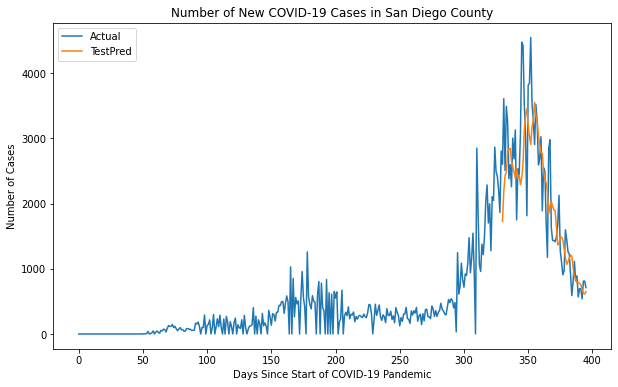

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(cases)
plt.plot(testpred)
plt.xlabel('Days Since Start of COVID-19 Pandemic')
plt.ylabel('Number of Cases')
plt.legend(['Actual', 'TestPred'])
plt.title(f'Number of New COVID-19 Cases in {c} County')
plt.savefig('San Diego Covid_prediction', bbox_inches='tight')